<a href="https://colab.research.google.com/github/liadekel/analyzing-big-data/blob/master/EX3_ClusteringMIMIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
from google.colab import auth
from google.cloud import bigquery
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
auth.authenticate_user()

In [3]:
import subprocess
import re

analysis_project = 'mimic-iii-71670'  #@param {type:"string"}

admissions_table = 'physionet-data.mimiciii_clinical.admissions'  # @param {type: "string"}
patients_table = 'physionet-data.mimiciii_clinical.patients'  # @param {type: "string"}
labs_table = 'physionet-data.mimiciii_clinical.labevents'  # @param {type: "string"}
d_labs_table = 'physionet-data.mimiciii_clinical.d_labitems'  # @param {type: "string"}
d_icd_diagnoses_table = 'physionet-data.mimiciii_clinical.d_icd_diagnoses'  # @param {type: "string"}
diagnoses_icd_table = 'physionet-data.mimiciii_clinical.diagnoses_icd'  # @param {type: "string"}

# Preprocess queries made with the %%bigquery magic
# by substituting these values
sub_dict = {
    'analysis_project': analysis_project,
    'admissions_table': admissions_table,
    'patients_table': patients_table,
    'labs_table': labs_table,
    'd_labs_table': d_labs_table,
    'd_icd_diagnoses_table': d_icd_diagnoses_table,
    'diagnoses_icd_table': diagnoses_icd_table,
    'ml_table_prefix': analysis_project + '.MIMIC.models_'
}

# Set the default project for running queries
bigquery.magics.context.project = analysis_project

In [4]:
# Set up the substitution preprocessing injection
# if bigquery.magics._run_query.func_name != 'format_and_run_query':
#   original_run_query = bigquery.magics._run_query
original_run_query = bigquery.magics._run_query
def format_and_run_query(client, query, job_config=None):
  query = query.format(**sub_dict)
  return original_run_query(client, query, job_config)

bigquery.magics._run_query = format_and_run_query

print('analysis_project:', analysis_project)
print()
print('custom %%bigquery magic substitutions:')
for k, v in sub_dict.items():
  print(' ', '{%s}' % k, '→', v)

analysis_project: mimic-iii-71670

custom %%bigquery magic substitutions:
  {analysis_project} → mimic-iii-71670
  {admissions_table} → physionet-data.mimiciii_clinical.admissions
  {patients_table} → physionet-data.mimiciii_clinical.patients
  {labs_table} → physionet-data.mimiciii_clinical.labevents
  {d_labs_table} → physionet-data.mimiciii_clinical.d_labitems
  {d_icd_diagnoses_table} → physionet-data.mimiciii_clinical.d_icd_diagnoses
  {diagnoses_icd_table} → physionet-data.mimiciii_clinical.diagnoses_icd
  {ml_table_prefix} → mimic-iii-71670.MIMIC.models_


In [5]:
%config InlineBackend.figure_format = 'svg'

In [6]:
bq = bigquery.Client(project=analysis_project)

In [7]:
bq.project

'mimic-iii-71670'

In [ ]:
if 'MIMIC' not in [d.dataset_id for d in list(bq.list_datasets())]:
  dataset_id = "{}.MIMIC".format(bq.project)
  # Construct a full Dataset object to send to the API.
  # Send the dataset to the API for creation.
  # Raises google.api_core.exceptions.Conflict if the Dataset already
  # exists within the project.

  dataset = bigquery.Dataset(dataset_id)
  dataset = bq.create_dataset(dataset)  # Make an API request.

Create `KMEANS` model:

In [ ]:
%%bigquery df 
CREATE OR REPLACE MODEL `{ml_table_prefix}las_kmeans_clustering`
OPTIONS(
model_type='kmeans', kmeans_init_method='KMEANS++',
num_clusters=4, standardize_features=true
)
AS
SELECT
  HADM_ID,
  ADMITTIME,
  CHARTTIME,
  ETHNICITY,
  ITEMID,
  GENDER,
  INSURANCE,
  ADMISSION_LOCATION,
  ADMISSION_TYPE,
  MARITAL_STATUS,
  # MIMIC3 sets all ages over 89 to 300 to avoid the possibility of
  # identification.
  IF(DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25 < 200,
  DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25, 95) AS AGE,
FROM
    (`{admissions_table}` AS adm
    INNER JOIN `{labs_table}` AS diag
    USING (HADM_ID, SUBJECT_ID))
    INNER JOIN `{patients_table}` AS patients
    USING (SUBJECT_ID)
WHERE DATETIME_DIFF(CHARTTIME, ADMITTIME,  MINUTE) >= 0 AND
      DATETIME_DIFF(CHARTTIME, ADMITTIME, MINUTE) <= 60 

Executing query with job ID: 428db36c-7711-42a0-97bc-5e6e62fb8939
Query executing: 94.83s

,HADM_ID,ADMITTIME,CHARTTIME,ETHNICITY,ITEMID,GENDER,INSURANCE,ADMISSION_LOCATION,ADMISSION_TYPE,MARITAL_STATUS,age
0,107312,2125-10-23 16:31:00,2125-10-23 17:17:00,BLACK/AFRICAN AMERICAN,51491,F,Medicare,TRANSFER FROM OTHER HEALT,EMERGENCY,MARRIED,65.232033
7,107312,2125-10-23 16:31:00,2125-10-23 17:17:00,BLACK/AFRICAN AMERICAN,51097,F,Medicare,TRANSFER FROM OTHER HEALT,EMERGENCY,MARRIED,65.232033
29,107312,2125-10-23 16:31:00,2125-10-23 17:17:00,BLACK/AFRICAN AMERICAN,51221,F,Medicare,TRANSFER FROM OTHER HEALT,EMERGENCY,MARRIED,65.232033
55,107312,2125-10-23 16:31:00,2125-10-23 17:17:00,BLACK/AFRICAN AMERICAN,51248,F,Medicare,TRANSFER FROM OTHER HEALT,EMERGENCY,MARRIED,65.232033
106,107312,2125-10-23 16:31:00,2125-10-23 17:17:00,BLACK/AFRICAN AMERICAN,51279,F,Medicare,TRANSFER FROM OTHER HEALT,EMERGENCY,MARRIED,65.232033
...,...,...,...,...,...,...,...,...,...,...,...
2231,107312,2125-10-23 16:31:00,2125-10-23 17:17:00,BLACK/AFRICAN AMERICAN,50960,F,Medicare,TRANSFER FROM OTHER HEALT,EMERGENCY,MARRIED,65.232033
2371,107312,2125-10-23 16:31:00,2125-10-23 17:17:00,BLACK/AFRICAN AMERICAN,51493,F,Medicare,TRANSFER FROM OTHER HEALT,EMERGENCY,MARRIED,65.232033
2405,107312,2125-10-23 16:31:00,2125-10-23 17:17:00,BLACK/AFRICAN AMERICAN,51200,F,Medicare,TRANSFER FROM OTHER HEALT,EMERGENCY,MARRIED,65.232033
2601,107312,2125-10-23 16:31:00,2125-10-23 17:17:00,BLACK/AFRICAN AMERICAN,51476,F,Medicare,TRANSFER FROM OTHER HEALT,EMERGENCY,MARRIED,65.232033


In [ ]:
%%bigquery comp_roc
SELECT * FROM ML.ROC_CURVE(MODEL `{ml_table_prefix}lab_adm_mortality_models`)

In [ ]:
def set_precision(df):
  df['precision'] = df.true_positives / (df.true_positives + df.false_positives)


def plot_precision_recall(df, label=None):
  # manually add the threshold = -∞ point
  df = df[df.true_positives != 0]
  recall = [0] + list(df.recall)
  precision = [1] + list(df.precision)
  # x=recall, y=precision line chart
  plt.plot(recall, precision, label=label)

Text(0, 0.5, 'Precision $\\left(\\frac{T_p}{T_p + F_p} \\right)$')

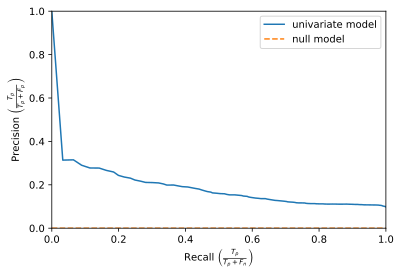

In [ ]:
set_precision(comp_roc)
plot_precision_recall(comp_roc, label='univariate model')
plt.plot(
    np.linspace(0, 1, 2), [comp_roc.precision.min()] * 2,
    label='null model',
    linestyle='--')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
plt.ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')